# TFがGPUを認識しているか確認

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8325757563734684059
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4146659328
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18265967020339238172
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Datasetの確認

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

In [4]:
ds,info = tfds.load('cifar10', 
                    split=['train','test'], 
                    shuffle_files=True,
                    as_supervised=True,
                    with_info=True)

In [5]:
print(f'ds = {ds}')
print(f'info = {info}')

ds = [<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, <PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]
info = tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='~/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'l

In [6]:
train_ds = ds[0]
test_ds = ds[1]

,image,label
0,,7 (horse)
1,,8 (ship)
2,,4 (deer)
3,,4 (deer)

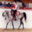
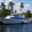
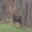
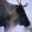

In [7]:
tfds.as_dataframe(train_ds.take(4),info)

# データセットの前処理

[参考](https://www.tensorflow.org/datasets/keras_example)

In [8]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32)/255.0, label

In [9]:
train_ds = train_ds.map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(info.splits['train'].num_examples)
train_ds = train_ds.batch(64)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

In [10]:
test_ds = test_ds.map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)
test_ds = test_ds.batch(64)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Callback関数の定義

[参考](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks?hl=ja)

In [11]:
%load_ext tensorboard

In [12]:
import os, datetime

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Tensorboardの表示

In [13]:
%tensorboard --logdir logs --host 0.0.0.0 --port 49551

# モデルの構築と学習

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32,32,3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [15]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [16]:
model.fit(
    train_ds,
    epochs = 100,
    validation_data=test_ds,
    callbacks = [tensorboard_callback]
)

Epoch 1/100
782/782 [==============================] - 9s 6ms/step - loss: 1.9189 - sparse_categorical_accuracy: 0.3171 - val_loss: 1.7829 - val_sparse_categorical_accuracy: 0.3658
Epoch 2/100
782/782 [==============================] - 3s 4ms/step - loss: 1.7654 - sparse_categorical_accuracy: 0.3721 - val_loss: 1.7737 - val_sparse_categorical_accuracy: 0.3767
Epoch 3/100
782/782 [==============================] - 3s 4ms/step - loss: 1.7047 - sparse_categorical_accuracy: 0.3963 - val_loss: 1.7155 - val_sparse_categorical_accuracy: 0.3910
Epoch 4/100
782/782 [==============================] - 3s 4ms/step - loss: 1.6601 - sparse_categorical_accuracy: 0.4125 - val_loss: 1.6455 - val_sparse_categorical_accuracy: 0.4079
Epoch 5/100
782/782 [==============================] - 3s 4ms/step - loss: 1.6332 - sparse_categorical_accuracy: 0.4204 - val_loss: 1.6392 - val_sparse_categorical_accuracy: 0.4143
Epoch 6/100
782/782 [==============================] - 3s 4ms/step - loss: 1.6116 - sparse_cate

782/782 [==============================] - 4s 5ms/step - loss: 1.4068 - sparse_categorical_accuracy: 0.4996 - val_loss: 1.5325 - val_sparse_categorical_accuracy: 0.4547
Epoch 47/100
782/782 [==============================] - 3s 4ms/step - loss: 1.4091 - sparse_categorical_accuracy: 0.4999 - val_loss: 1.5049 - val_sparse_categorical_accuracy: 0.4670
Epoch 48/100
782/782 [==============================] - 3s 4ms/step - loss: 1.3997 - sparse_categorical_accuracy: 0.5017 - val_loss: 1.5026 - val_sparse_categorical_accuracy: 0.4662
Epoch 49/100
782/782 [==============================] - 3s 4ms/step - loss: 1.3995 - sparse_categorical_accuracy: 0.5009 - val_loss: 1.5134 - val_sparse_categorical_accuracy: 0.4696
Epoch 50/100
782/782 [==============================] - 4s 4ms/step - loss: 1.3971 - sparse_categorical_accuracy: 0.5027 - val_loss: 1.5121 - val_sparse_categorical_accuracy: 0.4674
Epoch 51/100
782/782 [==============================] - 3s 4ms/step - loss: 1.3954 - sparse_categorical

782/782 [==============================] - 3s 4ms/step - loss: 1.3490 - sparse_categorical_accuracy: 0.5179 - val_loss: 1.5132 - val_sparse_categorical_accuracy: 0.4674
Epoch 92/100
782/782 [==============================] - 3s 4ms/step - loss: 1.3462 - sparse_categorical_accuracy: 0.5195 - val_loss: 1.5138 - val_sparse_categorical_accuracy: 0.4641
Epoch 93/100
782/782 [==============================] - 3s 4ms/step - loss: 1.3506 - sparse_categorical_accuracy: 0.5205 - val_loss: 1.5655 - val_sparse_categorical_accuracy: 0.4665
Epoch 94/100
782/782 [==============================] - 3s 4ms/step - loss: 1.3447 - sparse_categorical_accuracy: 0.5215 - val_loss: 1.5015 - val_sparse_categorical_accuracy: 0.4726
Epoch 95/100
782/782 [==============================] - 3s 4ms/step - loss: 1.3440 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.5443 - val_sparse_categorical_accuracy: 0.4575
Epoch 96/100
782/782 [==============================] - 3s 4ms/step - loss: 1.3420 - sparse_categorical